In [10]:
from pyspark.sql import SparkSession

# Spark session & context
spark = (SparkSession
         .builder
         .master('local')
         .appName('wiki-changes-dataviz')
         .config("spark.sql.streaming.schemaInference", True) #Stream dataframe infers schema
         .getOrCreate())
sc = spark.sparkContext

In [11]:
# Read parquet stream
df_stream = (
    spark
    .readStream
    .format("parquet")
    .load("C:/BigData/data-lake/wiki-changes")
)

In [12]:
# Create dataframe grouping by window 
from pyspark.sql.functions import window, col, current_timestamp

df_count = (
    df_stream
    .withWatermark("change_timestamp", "10 minutes") # Don't aggregate events arriving more than 10 minutes late
    .groupBy(
        window(col("change_timestamp"), "10 minutes", "10 minutes"), # 10 minute window, updating every 10 minutes
        col("user"))
    .count()
)

In [13]:
# Create query stream with memory sink
queryStream = (df_count
 .writeStream
 .format("memory")
 .queryName("wiki_changes")
 .outputMode("update")
 .start())

**********************
General Info
**********************
Run:68
Stream timestamp:2021-10-06T10:49:19.749Z
Total Rows:2169
Updated Rows:0
**********************
Graph - Top 10 users
**********************


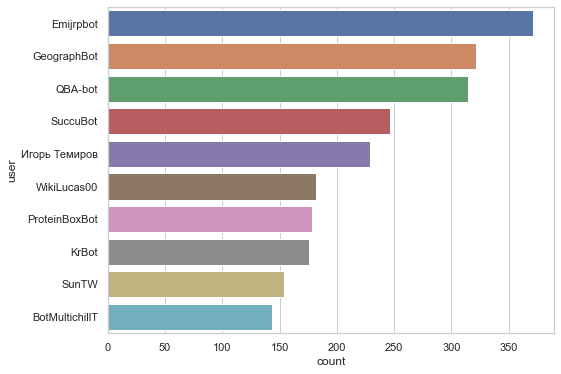

**********************
Table - Top 10 users
**********************


,start,end,user,count
0,2021-09-18 22:00:00,2021-09-18 22:10:00,Emijrpbot,371
1,2021-09-18 22:00:00,2021-09-18 22:10:00,GeographBot,321
2,2021-09-18 22:00:00,2021-09-18 22:10:00,QBA-bot,314
3,2021-09-18 22:00:00,2021-09-18 22:10:00,SuccuBot,246
4,2021-09-18 22:00:00,2021-09-18 22:10:00,Игорь Темиров,229
5,2021-09-18 22:00:00,2021-09-18 22:10:00,WikiLucas00,182
6,2021-09-18 22:00:00,2021-09-18 22:10:00,ProteinBoxBot,178
7,2021-09-18 22:00:00,2021-09-18 22:10:00,KrBot,176
8,2021-09-18 22:00:00,2021-09-18 22:10:00,SunTW,154
9,2021-09-18 22:00:00,2021-09-18 22:10:00,BotMultichillT,143


process interrupted.


In [14]:
from time import sleep
from IPython.display import clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(queryStream.recentProgress) > 0):
            print("Stream timestamp:{}".format(queryStream.lastProgress["timestamp"]))
#             print("Watermark:{}".format(queryStream.lastProgress["eventTime"]["watermark"]))
            print("Total Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsTotal"]))
            print("Updated Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsUpdated"]))
#             print("Memory used MB:{}".format((queryStream.lastProgress["stateOperators"][0]["memoryUsedBytes"]) * 0.000001))
            
        df = spark.sql(
                """
                    select
                        window.start
                        ,window.end
                        ,user
                        ,sum(count) count
                    from
                        wiki_changes
                    where
                        window.start = (select max(window.start) from wiki_changes)
                    group by
                        window.start
                        ,window.end
                        ,user
                    order by
                        4 desc
                    limit 10
                """
        ).toPandas()

        # Plot the total crashes
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(8,6))

        print("**********************")
        print("Graph - Top 10 users")
        print("**********************")
        try:
            # Barplot
            sns.barplot(x="count", y="user", data=df)

            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass

        print("**********************")
        print("Table - Top 10 users")
        print("**********************")
        display(df)
        
#         print("**********************")
#         print("Table - Count by aggregation window")
#         print("**********************")
#         df1 = spark.sql(
#                 """
#                     select
#                         window.start
#                         ,window.end
#                         ,sum(count) qty_lines
#                         ,count(distinct user) qty_users
#                     from
#                         wiki_changes
#                     group by
#                         window.start
#                         ,window.end
#                     order by
#                         window.start desc
#                 """
#         ).toPandas()
        
#         display(df1)
        
        sleep(10)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")

In [ ]:
# Check active streams
for s in spark.streams.active:
    print("ID:{} | NAME:{}".format(s.id, s.name))

In [9]:
# Stop stream
queryStream.stop()